# Capstone Project - The Battle of Neighborhoods

## What are the best neighborhood for students in Toronto?

### Procedure: 

In [1]:
## Import libraries

import requests
import urllib.request
import bs4 as bs
import pandas as pd
import numpy as np

In [2]:
## get the url
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
sauce = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(sauce, 'lxml')

## table with the html code of the table
table = soup.table

## append rows from the table in html to a list
table_rows = table.find_all('tr')
rows = list()
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    rows.append(row)

In [3]:
## convert the list to a dataframe
df = pd.DataFrame(rows)
df.columns = ['PostCode', 'Borough', 'Neighbourhood']
df.drop(df.index[0], inplace=True)

## take out the "not assigned from Borough"
df2 = df.loc[df['Borough'] != "Not assigned"]

## take out the "\n" from the strings
df2['Neighbourhood'] = df2['Neighbourhood'].replace('\n','', regex = True)

## Replace the "Not assigned" neighbourhood with the Borough
df2['Neighbourhood'] = df2['Neighbourhood'].replace('Not assigned',df2['Borough'], regex = True)

## rest index numbers in the dataframe
df2 = df2.reset_index(drop=True)

## Group by Postcode and aggrgate neighbourhood strings
df3 = df2.groupby(['PostCode', 'Borough'], sort = False, as_index = False).agg(lambda col: ', '.join(col))

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [4]:
df_data_1 = pd.read_csv("/resources/data/Geo_Coor.csv")
df_final = pd.merge(df3, df_data_1, 
         left_on=['PostCode'], right_on=['Postal Code'], how='left')
del df_final['Postal Code']

In [5]:
# Amount of Neighborhoods in each Borough
df_plot = df_final.groupby(['Borough']).count()
df_plot['Neighbourhood'].plot(kind='bar')

In [6]:
#libraries for clustering 

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2p             |       h470a237_1         3.1 MB  conda-forge
    certifi-2018.10.15         |        py36_1000         138 KB  conda-forge
    geopy-1.17.0               |             py_0          49 KB  conda-forge
    ca-certificates-2018.10.15 |       ha4d7672_0         135 KB  conda-forge
    conda-4.5.11               |        py36_1000         651 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.1 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0            conda-forge
    geopy:           

In [7]:
latitude = 43.6532
longitude = -79.3832
CLIENT_ID = '1BCAN0K1EBXSXDRBGVE0LLHC3BJLAESBP4QPCL53PDJP5UOT' # your Foursquare ID
CLIENT_SECRET = 'HH4IYGIQUNM4VXXIUSBYZME1C0PDSHVXQOHOTMFXJF2YLVEK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [8]:
LIMIT = 100
radius = 200
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
##df_final2 = df_final[df_final['Borough'] == "Downtown Toronto"].reset_index(drop=True)
df_final3 = df_final[df_final['Borough'] == "Downtown Toronto"].reset_index(drop=True)
df_final4 = df_final[df_final['Borough'] == "Central Toronto"].reset_index(drop=True)
df_final5 = df_final[df_final['Borough'] == "East Toronto"].reset_index(drop=True)
df_final6 = df_final[df_final['Borough'] == "West Toronto"].reset_index(drop=True)

frames = [df_final3, df_final4, df_final5, df_final6]
df_toronto = pd.concat(frames)
df_final2 = df_toronto.reset_index(drop=True)

toronto_venues = getNearbyVenues(names=df_final2['Neighbourhood'],
                                   latitudes=df_final2['Latitude'],
                                   longitudes=df_final2['Longitude']
                                  )

Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Christie
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
First Canadian Place, Underground city
Church and Wellesley
Lawrence Park
Roselawn
Davisville North
Forest Hill North, Forest Hill West
North Toronto West
The Annex, North Midtown, Yorkville
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Business reply mail Processing Centre969 Eastern
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, E

In [10]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pizza Place,Plane,Playground,Plaza,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

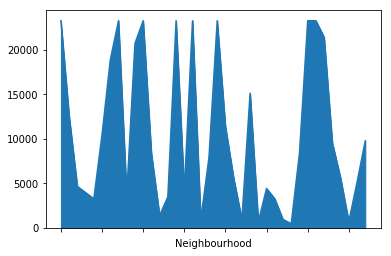

In [11]:
torono_onehot_vi = toronto_onehot.groupby(['Neighbourhood']).count()
torono_onehot_vi['my_sum'] = torono_onehot_vi.iloc[:, 1:].sum(1)
torono_onehot_vi['my_sum'].plot(kind='area')

In [12]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()

In [13]:
num_top_venues = 10

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.06
2           Steakhouse  0.04
3  American Restaurant  0.04
4      Thai Restaurant  0.04
5                  Bar  0.03
6                Hotel  0.03
7                  Gym  0.03
8       Cosmetics Shop  0.03
9           Restaurant  0.03


----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.06
2          Restaurant  0.04
3          Steakhouse  0.04
4              Bakery  0.04
5         Cheese Shop  0.04
6            Beer Bar  0.04
7                Café  0.04
8  Seafood Restaurant  0.04
9      Farmers Market  0.04


----Brockton, Exhibition Place, Parkdale Village----
                    venue  freq
0             Coffee Shop  0.15
1                    Café  0.10
2          Breakfast Spot  0.10
3       Convenience Store  0.05
4      Italian Restaurant  0.05
5           Burrito Place  0.05
6      Falafel Restaurant  0.05
7      

In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [15]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

In [16]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2],
      dtype=int32)

In [17]:
toronto_merged = df_final2

# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged # check the last columns!

,PostCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,2,Coffee Shop,Bakery,Café,Park,Mexican Restaurant
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,2,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Bar
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Restaurant,Clothing Store,Hotel
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Farmers Market
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,2,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Bar
5,M6G,Downtown Toronto,Christie,43.669542,-79.422564,2,Grocery Store,Café,Park,Athletics & Sports,Coffee Shop
6,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,2,Coffee Shop,Café,Steakhouse,American Restaurant,Thai Restaurant
7,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,2,Coffee Shop,Hotel,Café,Aquarium,Pizza Place
8,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,2,Coffee Shop,Hotel,Café,American Restaurant,Italian Restaurant
9,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,2,Coffee Shop,Hotel,Café,Restaurant,American Restaurant


In [19]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters